In [1]:
#*********************@Author: Aniruddh Khera*********************
# About the data: S&P500 companies stock prices from 2010-2016
# Here I analyzed for GOOGLE, we can do it for other
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import *
import theano
floatX = theano.config.floatX
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("nyse/prices-split-adjusted.csv")

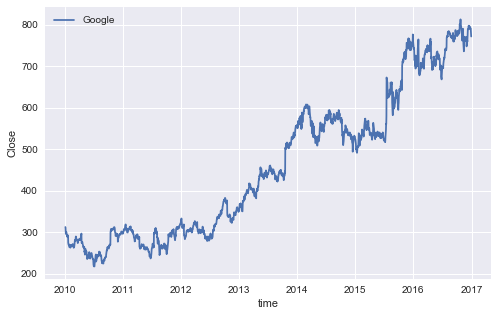

In [2]:
#**********************EXPLORATORY ANALYSIS**********************
#select google
goog = df[df.symbol == 'GOOG']
goog.date = goog.date.convert_objects(convert_dates='coerce')
goog = goog.sort_index(by="date")
goog = goog.set_index("date")
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(goog['close'], label='Google')
ax.set(xlabel='time', ylabel='Close')
ax.legend();


In [3]:
# Split data into training & testing
goog_train = goog[goog.index<'2016-12-14']
goog_test = goog[goog.index>='2016-12-14']

# Take log to make variance constant
goog_train['Log close'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_train['Log open'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_test['Log close'] = goog_test['close'].apply(lambda x: np.log(x))  
goog_test['Log open'] = goog_test['close'].apply(lambda x: np.log(x))  


In [4]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size,
                           shape=len(goog_train['Log close']))

    nu = pm.Exponential('nu', .1)

    r = pm.StudentT('r', nu=nu,
                    lam=pm.math.exp(-2*s),
                    observed=goog_train['Log close'])

In [6]:
with model:
    trace = pm.sample(nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [14:46<00:00,  2.62it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1122d1b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1130574d0>]], dtype=object)

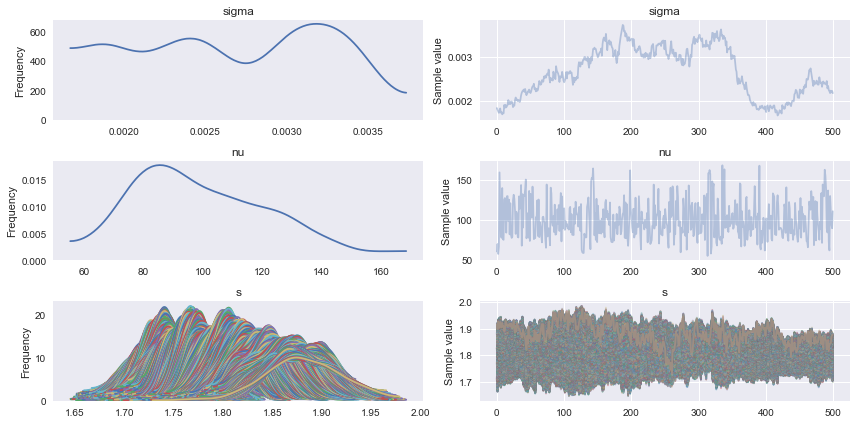

In [13]:
pm.traceplot(trace, varnames=['sigma', 'nu', 's'])

In [21]:
trace[s].shape

(500, 1751)

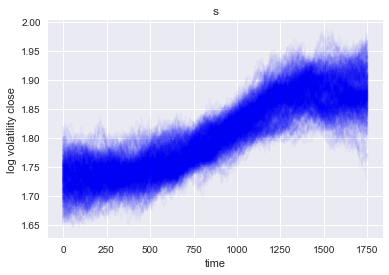

In [18]:
fig, ax = plt.subplots()

plt.plot(trace['s'].T, 'b', alpha=.03);
ax.set(title=str(s), xlabel='time', ylabel='log volatility close');

In [ ]:
fig, ax = plt.subplots()
#ax.plot(goog_train['Log close'])
#ax.plot(np.exp(trace[s].T), 'r', alpha=.03)

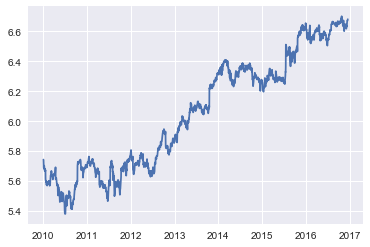

In [43]:
fig, ax = plt.subplots()
ax.plot(goog_train['Log close'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(goog_train['Log close'])
ax.plot(np.exp(trace[s]), 'r', alpha=.03)
ax.set(xlabel='time', ylabel='log close price')
ax.legend(['S&P500', 'stoch vol']);

In [83]:
goog_train['Log close'].shape[0]

1750

In [5]:
# Trying to emulate http://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/
import theano.tensor as tt
interval = 10
def construct_nn(ann_input, ann_output):   
    n_hidden =  5

    # Initialize random weights between each layer
    init_1 = np.random.randn(1, n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)   
    with pm.Model() as neural_network:
    
        # Weights from input to hidden layer   
        step_size = pm.HalfNormal('step_size', 
                                  sd=np.ones(n_hidden), 
                                  shape=n_hidden)
        weights_in_1 = pm.GaussianRandomWalk('w1', 
                                             sd=step_size, 
                                             shape=(interval, 1, n_hidden),
                                             testval=np.tile(init_1, (interval, 1, 1))
                                            )
        weights_in_1_rep = tt.repeat(weights_in_1, 
                                   ann_input.shape[0]//interval, 
                                   axis=0)
        weights_1_2 = pm.Normal('w2', 
                                mu=0, 
                                sd=1., 
                                shape=(1, n_hidden, n_hidden),
                                testval=init_2)
        weights_1_2_rep = tt.repeat(weights_1_2, 
                                   ann_input.shape[0],
                                   axis=0)
        weights_2_out = pm.Normal('w3', 
                                  mu=0, 
                                  sd=1.,
                                  shape=(1, n_hidden),
                                  testval=init_out)
        weights_2_out_rep = tt.repeat(weights_2_out, 
                                      ann_input.shape[0],
                                        axis = 0)
     

        # Build neural-network using tanh activation function
        act_1 =  tt.tanh(tt.batched_dot(ann_input, weights_in_1_rep))
        act_2 =  tt.tanh(tt.batched_dot(act_1, weights_1_2_rep))
        act_out = tt.batched_dot(act_2,weights_2_out_rep)
        out = pm.Normal('out', act_out, observed=ann_output)
    return neural_network

ann_input = theano.shared(np.array(goog_train['Log open']))
ann_output = theano.shared(np.array(goog_train['Log close']))
neural_network = construct_nn(ann_input, ann_output)

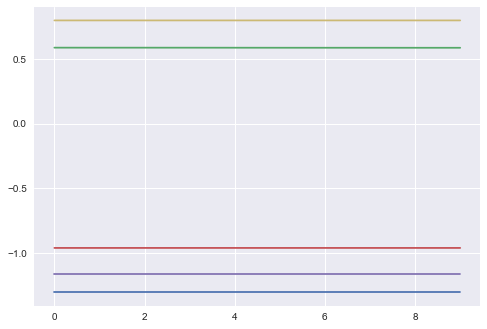

In [6]:
import scipy.optimize
with neural_network:
    map_est = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)



In [8]:
map_estttt['w1'].shape
#plt.plot(map_est['w1'].reshape(interval, 5))


(10, 1, 5)

In [7]:
with neural_network:
    trace = pm.sample(100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 600/600 [2:29:06<00:00, 20.16s/it]    


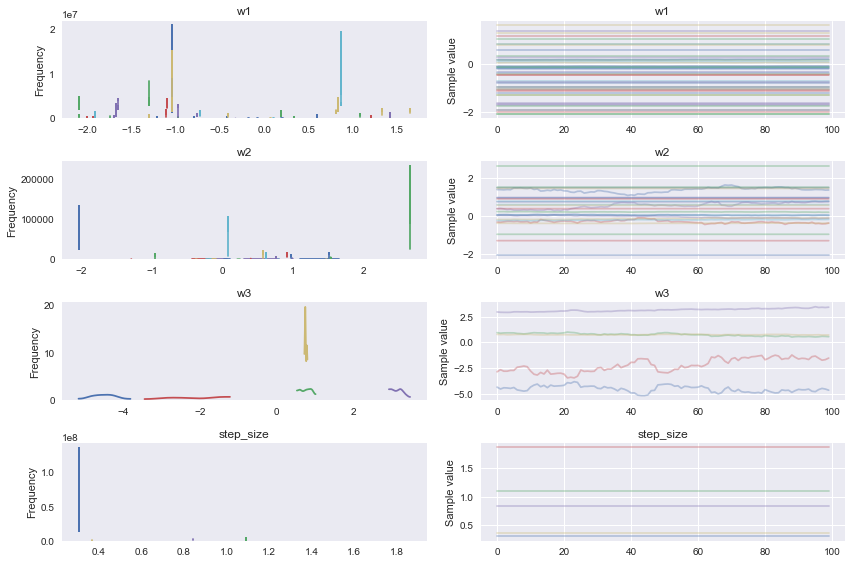

In [9]:
with neural_network:
    pm.traceplot(trace)

In [10]:
with neural_network:
    ppc = pm.sample_ppc(trace)
    

100%|██████████| 100/100 [00:00<00:00, 526.72it/s]


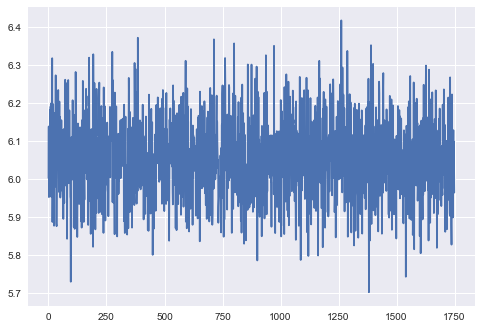

In [11]:
plt.plot(ppc['out'].mean(axis=0))

In [79]:
neural_network.out.distribution

In [80]:
import scipy.optimize
with neural_network:
    map_est = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)
    

logp = -38,507:   2%|▏         | 82/5000 [00:00<00:10, 480.43it/s]


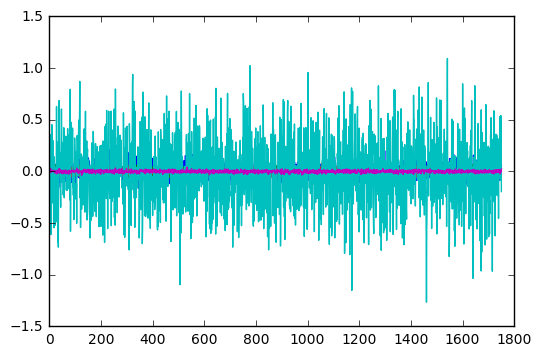

In [105]:
plt.plot(map_est['w1'])

In [99]:
ppc = pm.sample_ppc([map_est], model=neural_network)
print('Accuracy on train data = {:.2f}%'.format((ppc['out'] == goog_train['Log close']).mean() * 100))

100%|██████████| 1/1 [00:00<00:00, 891.84it/s]


ValueError: Lengths must match to compare

In [102]:
ann_input.set_value(goog_test['Log open'])
ann_output.set_value(goog_test['Log close'])
with neural_network:
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['out'].mean(axis=0)
    proba = ppc['out'].std(axis=0)

  0%|          | 0/500 [00:00<?, ?it/s]


ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, w1.T, <TensorType(float64, vector)>, TensorConstant{0.0})
Toposort index: 11
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(5,), (), (5, 1751), (11,), ()]
Inputs strides: [(8,), (), (8, 40), (8,), ()]
Inputs values: [array([  0.00000000e+000,   4.94065646e-324,   9.88131292e-324,
         1.48219694e-323,   1.97626258e-323]), array(1.0), 'not shown', 'not shown', array(0.0)]
Outputs clients: [[Elemwise{Tanh}[(0, 0)](CGemv{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.